In [1]:
import os
import sys

import matplotlib.pyplot as plt

os.chdir('..')

import numpy as np
import torch
import pandas as pd
from models.TrainPlanningOperator2D import PlanningOperator2D
from heuristics import generaterandompos
from heuristics import euclideannorm, FMM, dijkstra, planningoperator
from heuristics import testheuristiconmaps, testheuristiconsinglemap



Load Test Maps

In [2]:
Ntotal = 550
ntest = 50
sub = 1
Sx = Sy = int(((512 - 1) / sub) + 1)
maps = np.load('dataset/street_maps_512x512_dijkstra/mask.npy')
maps = maps[:Ntotal][-ntest:, ::sub, ::sub][:, :Sx, :Sy]
maps = maps[30:31,:,:].reshape(1,Sx,Sy)

Generate Random Start and Goal Positions on Maps

In [3]:
startpositions = generaterandompos(maps)
goalpositions = generaterandompos(maps)

Comparing Euclidean Norm, FMM, Dijkstra Heuristic

Testing Euclidean Norm
Average Path Cost: 265.0193359837565 
Average Planning Time: 0.661264181137085 
Average Inference Time: 0.01749420166015625 
Average Number of Node Expansions: 13237.0 
Average Success Rate: 1.0
Testing FMM
Average Path Cost: 265.0193359837565 
Average Planning Time: 0.35344457626342773 
Average Inference Time: 0.07940340042114258 
Average Number of Node Expansions: 7632.0 
Average Success Rate: 1.0
Testing Dijkstra
Average Path Cost: 265.0193359837565 
Average Planning Time: 0.348966121673584 
Average Inference Time: 7.738535404205322 
Average Number of Node Expansions: 5372.0 
Average Success Rate: 1.0


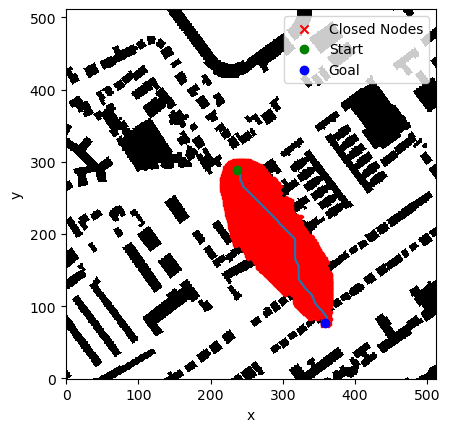

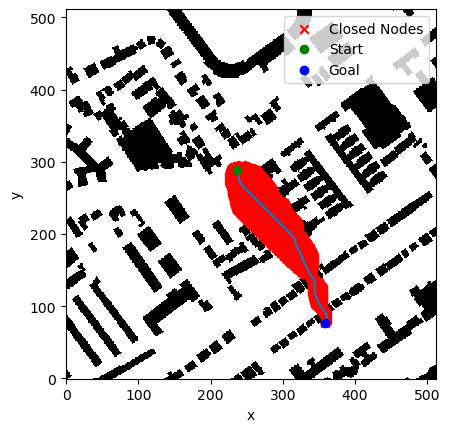

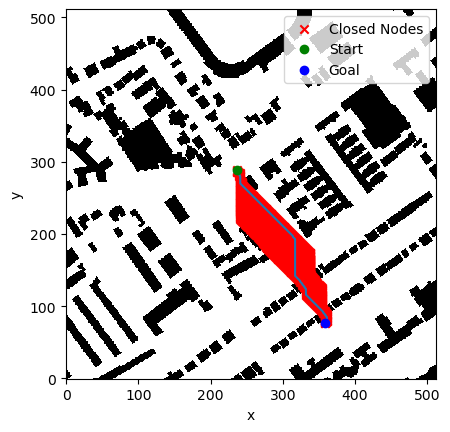

In [4]:
# Euclidean Norm
print("Testing Euclidean Norm")
euclidean_results = testheuristiconmaps(startpositions, goalpositions, maps, euclideannorm, plotresults=True, printvalues=True)


# FMM
print("Testing FMM")
fmm_results = testheuristiconmaps(startpositions, goalpositions, maps, FMM, plotresults=True, printvalues=True)

# Dijkstra
print("Testing Dijkstra")
dijkstra_results = testheuristiconmaps(startpositions, goalpositions, maps, dijkstra, plotresults=True, printvalues=True)


# data = {
#     "Heuristic": ["Euclidean Norm", "FMM", "Dijkstra","Neural Operator"],
#     "Avg Path Cost": [euclidean_results[0], fmm_results[0], dijkstra_results[0]],
#     "Avg Planning Time": [euclidean_results[1], fmm_results[1], dijkstra_results[1]],
#     "Avg Inference Time": [euclidean_results[2], fmm_results[2], dijkstra_results[2]],
#     "Avg Nodes Expanded": [euclidean_results[3], fmm_results[3], dijkstra_results[3],],
#     "Avg Success Rate": [euclidean_results[4], fmm_results[4], dijkstra_results[4],],
# }


# results_df = pd.DataFrame(data)


# results_df

Planning Operator

Testing NO
Erode Time 0.0052890777587890625
SDF Time 0.011192560195922852
NO time: 0.3390352725982666
Average Path Cost: 276.43354954613005 
Average Planning Time: 0.029331445693969727 
Average Inference Time: 0.3677496910095215 
Average Number of Node Expansions: 567.0 
Average Success Rate: 1.0


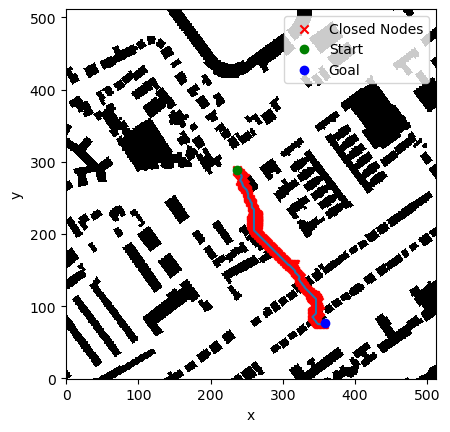

In [5]:
# Model
modes = 13
width = 32
nlayers = 5

model = PlanningOperator2D(modes, modes, width, nlayers)
model.load_state_dict(torch.load("trained_models/modeldijkstra512.ckpt"))
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

erosion_values = []
avgpathcost_values = []
avgplantime_values = []
avginfertime_values = []
avgnodesexp_values = []
avgsuccessrate_values = []

# NO
print("Testing NO")
no_results = testheuristiconmaps(startpositions, goalpositions, maps, planningoperator,  model=model,plotresults=True, printvalues=True, erosion = 12)


In [ ]:

# Run the loop and store results
for erode in range(1, 25):
    
    # Call your function and store the results
    avgpathcost, avgplantime, avginfertime, avgnodesexp, avgsuccessrate = testheuristiconmaps(
        startpositions, goalpositions, maps, planningoperator, model=model, erosion=erode, plotresults=False, printvalues=False
    )
    
    # Append results to lists
    erosion_values.append(erode)
    avgpathcost_values.append(avgpathcost)
    avgplantime_values.append(avgplantime)
    avginfertime_values.append(avginfertime)
    avgnodesexp_values.append(avgnodesexp)
    avgsuccessrate_values.append(avgsuccessrate)

# Plotting the results
plt.figure(figsize=(14, 8))

# Plot for avgpathcost
plt.subplot(3, 2, 1)
plt.plot(erosion_values, avgpathcost_values, marker='o')
plt.title('Average Path Cost vs Erosion')
plt.xlabel('Erosion')
plt.ylabel('Avg Path Cost')

# Plot for avgplantime
plt.subplot(3, 2, 2)
plt.plot(erosion_values, avgplantime_values, marker='o')
plt.title('Average Planning Time vs Erosion')
plt.xlabel('Erosion')
plt.ylabel('Avg Planning Time')

# Plot for avginfertime
plt.subplot(3, 2, 3)
plt.plot(erosion_values, avginfertime_values, marker='o')
plt.title('Average Inference Time vs Erosion')
plt.xlabel('Erosion')
plt.ylabel('Avg Inference Time')

# Plot for avgnodesexp
plt.subplot(3, 2, 4)
plt.plot(erosion_values, avgnodesexp_values, marker='o')
plt.title('Average Nodes Expanded vs Erosion')
plt.xlabel('Erosion')
plt.ylabel('Avg Nodes Expanded')

# Plot for avgsuccessrate
plt.subplot(3, 2, 5)
plt.plot(erosion_values, avgsuccessrate_values, marker='o')
plt.title('Average Success Rate vs Erosion')
plt.xlabel('Erosion')
plt.ylabel('Avg Success Rate')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()